<a href="https://colab.research.google.com/github/Erssa001/ECGR_4105/blob/main/HW6_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/2023-2024/ECGR_4105/Housing.csv'
dataset = pd.DataFrame(pd.read_csv(file_path))

bi_vars =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
dataset[bi_vars] = dataset[bi_vars].apply(binary_map)
# Preprocessing


components_to_use = ['area', 'bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning', 'parking', 'prefarea']
X = torch.tensor(dataset[components_to_use].values.copy(), dtype=torch.float32)

scaler = MinMaxScaler()
dataset[num_vars] = scaler.fit_transform(dataset[num_vars])
X_n = torch.tensor(dataset[components_to_use].values.copy(), dtype=torch.float32)

Y = torch.tensor(dataset.pop('price').values, dtype=torch.float32)

In [ ]:
n_samples = X.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

X_train = X[train_indices]
Y_train = Y[train_indices]

X_test = X[val_indices]
Y_test = Y[val_indices]

X_n_train = X_n[train_indices]
X_n_test = X_n[val_indices]

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, X_test, Y_train, Y_test):
  plotted_loss = np.zeros(n_epochs)
  for epoch in range(1, n_epochs + 1):
    Y_pred_train = model(X_train)
    train_loss = loss_fn(Y_pred_train, Y_train)

    with torch.no_grad(): # <1>
      Y_pred_test = model(X_test)
      test_loss = loss_fn(Y_pred_test, Y_test)
      plotted_loss[epoch - 1] = test_loss
      assert test_loss.requires_grad == False # <2>

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if ((epoch == 1) or (epoch % 1000 == 0)):
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {test_loss.item():.4f}")

  return plotted_loss

In [ ]:
linear_model = nn.Linear(X.shape[1], 1)

seq_model_1 = nn.Sequential(
  nn.Linear(X.shape[1], 32),
  nn.Tanh(),
  nn.Linear(32, 1)
)

seq_model_2 = nn.Sequential(
  nn.Linear(X.shape[1], 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 16),
  nn.Tanh(),
  nn.Linear(16, 1)
)

linear_optimizer = optim.SGD(linear_model.parameters(), lr=1e-3)
seq_optimizer_1 = optim.SGD(seq_model_1.parameters(), lr=1e-3)
seq_optimizer_2 = optim.SGD(seq_model_2.parameters(), lr=1e-3)

epochs = 10000

lin_reg = training_loop(
    n_epochs = epochs,
    optimizer = linear_optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    X_train = X_n_train, # <1>
    X_test = X_n_test, # <1>
    Y_train = Y_train,
    Y_test = Y_test)

single_seq = training_loop(
    n_epochs = epochs,
    optimizer = seq_optimizer_1,
    model = seq_model_1,
    loss_fn = nn.MSELoss(),
    X_train = X_n_train, # <1>
    X_test = X_n_test, # <1>
    Y_train = Y_train,
    Y_test = Y_test)

multi_seq = training_loop(
    n_epochs = epochs,
    optimizer = seq_optimizer_2,
    model = seq_model_2,
    loss_fn = nn.MSELoss(),
    X_train = X_n_train, # <1>
    X_test = X_n_test, # <1>
    Y_train = Y_train,
    Y_test = Y_test)

# for name, param in seq_model.named_parameters():
#     print(f"Parameter name: {name}, Size: {param.size()}")

Epoch 1, Training loss 0.1272, Validation loss 0.1365
Epoch 1000, Training loss 0.0437, Validation loss 0.0519
Epoch 2000, Training loss 0.0334, Validation loss 0.0419
Epoch 3000, Training loss 0.0291, Validation loss 0.0377
Epoch 4000, Training loss 0.0272, Validation loss 0.0357
Epoch 5000, Training loss 0.0262, Validation loss 0.0347
Epoch 6000, Training loss 0.0257, Validation loss 0.0341
Epoch 7000, Training loss 0.0254, Validation loss 0.0338
Epoch 8000, Training loss 0.0252, Validation loss 0.0336
Epoch 9000, Training loss 0.0250, Validation loss 0.0334
Epoch 10000, Training loss 0.0249, Validation loss 0.0333
Epoch 1, Training loss 0.3689, Validation loss 0.3679
Epoch 1000, Training loss 0.0294, Validation loss 0.0381
Epoch 2000, Training loss 0.0270, Validation loss 0.0355
Epoch 3000, Training loss 0.0259, Validation loss 0.0344
Epoch 4000, Training loss 0.0254, Validation loss 0.0339
Epoch 5000, Training loss 0.0252, Validation loss 0.0336
Epoch 6000, Training loss 0.0250, Va

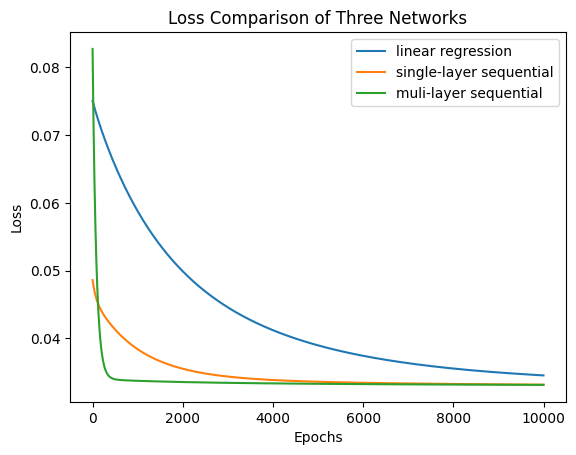

In [ ]:
# Plotting the losses
plt.plot(range(epochs), lin_reg, label='linear regression')
plt.plot(range(epochs), single_seq, label='single-layer sequential')
plt.plot(range(epochs), multi_seq, label='muli-layer sequential')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison of Three Networks')

# Adding legend
plt.legend()

# Show the plot
plt.show()